# <center> Gender Biais detection</center>
## <center> Application of the Bolukbasi Paper to the french  </center>
### <center> Quillivic Robin </center>
Sources : Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings, Bolukbasi, Tolga, 2016

In [9]:
from gensim import *
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import logging
import gensim
import os

import itertools

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from random import *

import pandas as pd
import numpy as np
import math

from sklearn.decomposition import PCA
import lib
import fasttext
from gensim.models.wrappers import FastText

from sklearn.metrics import roc_auc_score,accuracy_score

C:\Users\Robin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [21]:
# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load pre-trained Word2Vec model.
model  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\cc.fr.300.vec', binary=False,limit=70000)
model_lem  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin', binary=True,limit=70000)
#model  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\fr_Kyubyong_wordvectors.vec',binary=False,limit=50000)
model_wiki  = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\FR\wiki_fr.vec',binary=False,limit=70000)
model_wiki_lem  = gensim.models.KeyedVectors.load_word2vec_format('C:/Users/Robin/Documents/IMPACT/Notebooks/DATA/FR/ppmi_svd_fr/matrix.txt',binary=False,encoding='latin1')
# normalizeation :
model.init_sims(True)
model_lem.init_sims(True)
model_wiki.init_sims(True)
model_wiki_lem.init_sims(True)

2019-03-13 15:07:24,928 : INFO : loading projection weights from DATA\FR\cc.fr.300.vec
2019-03-13 15:07:45,793 : INFO : loaded (70000, 300) matrix from DATA\FR\cc.fr.300.vec
2019-03-13 15:07:45,794 : INFO : loading projection weights from DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin
2019-03-13 15:07:47,163 : INFO : loaded (70000, 500) matrix from DATA\FR\frWac_no_postag_no_phrase_500_skip_cut100.bin
2019-03-13 15:07:47,183 : INFO : loading projection weights from DATA\FR\wiki_fr.vec
2019-03-13 15:08:10,811 : INFO : loaded (70000, 300) matrix from DATA\FR\wiki_fr.vec
2019-03-13 15:08:10,826 : INFO : loading projection weights from C:/Users/Robin/Documents/IMPACT/Notebooks/DATA/FR/ppmi_svd_fr/matrix.txt
2019-03-13 15:08:49,449 : INFO : loaded (53376, 500) matrix from C:/Users/Robin/Documents/IMPACT/Notebooks/DATA/FR/ppmi_svd_fr/matrix.txt
2019-03-13 15:08:49,467 : INFO : precomputing L2-norms of word weight vectors
2019-03-13 15:08:50,172 : INFO : precomputing L2-norms of word w

## 1) Find gender pair of word associated with gender

In [27]:
def association_Genrator(w1,w2,model,top_n=1000):
    """
    return a data frame ordered by the most similar pair of the W1,W2
    """
    # we build a dataframe with the vocabulary
    df = pd.DataFrame(list(model.vocab.items()), columns=['word','count'])
    # we drop the index of the word entry
    k = df[df['word']==w1].index[0]
    j = df[df['word']==w2].index[0]
    liste = df['word'].drop([k,j]).values[:top_n]
    # we compute the length of the iteration to informethe user that the process could be long
    N=math.factorial(len(liste))/(math.factorial(len(liste)-2)*math.factorial(2))
    # init
    a = model[w1]-model[w2]
    S =[]
    P=[]
    i=0
    # we compute the similarity score
    for x in itertools.combinations(liste,2) :
        u = model[x[0]]-model[x[1]]
        S.append(lib.cosine_similarity(a,u))
        P.append(x)
        i+=1
        # print the progression
        if i%1000000==0:
            print(i/N*100,'%')
            
    # storing and ordering
    res = pd.DataFrame(data={'pair':P,'score':S})
    res['score'] = abs(res['score']) #get absolute value
    res = res.sort_values(by='score',ascending=False,inplace=False)
    return(res)

In [28]:
res_HF = association_Genrator('fille','garçon',model,top_n=1000)
res_HF.head(20)

,pair,score
338105,"(seul, seule)",0.639529
260533,"(homme, femme)",0.618795
218772,"(petit, petite)",0.586632
424658,"(père, mère)",0.576565
404195,"(ancien, ancienne)",0.553337
41099,"(Le, La)",0.533148
219007,"(petit, seule)",0.529449
219223,"(petit, mère)",0.528744
44051,"(La, Un)",0.514276
218945,"(petit, belle)",0.509544


In [36]:
res_HF = association_Genrator('le','la',model_wiki,top_n=1000)
res_HF.head(20)

,pair,score
409596,"(laquelle, lequel)",0.615694
16847,"(un, une)",0.571886
29545,"(son, sa)",0.564418
354168,"(seul, seule)",0.557817
33421,"(ce, cette)",0.548383
2011,"(de, un)",0.502066
109459,"(tout, toute)",0.498307
16880,"(un, cette)",0.480216
29555,"(son, cette)",0.478067
17844,"(une, ce)",0.475957


## Comment :
The gender pair generator we have built is not really meaningfull. We decided to create our own pair of word using our knowledge of French langage.
We create :
* **pair_g**: gender pairs associated with the determinants and pronoums
* **pair_g1**: gender pairs associated with semantic signification
* **pair_g2**: gender pairs associated with suffix

In [119]:
pair_g = [['la','le'],['elle','il'], ['cette', 'cet'],
          ['une','un'],['laquelle', 'lequel'],['celle','celui'],['ma','mon'],
          ['mienne','mien'],['certaine', 'certain'],['aucune', 'aucun']
         ]

pair_g1 = [['fille','garçon'],['maman','papa'],['mère','père'],['fille','fils'],['femelle','mâle'],
           ['reine','roi'],['tante','oncle'],['grand-père','grand-mère'],
           ['femme','homme'],['soeur','frère'],['marraine','parrain']
          ]


pair_g2 = [['belle','beau'],['actrice','acteur'],['serveuse','serveur'],['contente' ,'content'],
           ['petite','petit'],['heureuse','heureux'],['gentille','gentils'],['seule', 'seul'],
           ['créatrice','créateur'],['chanteuse','chanteuse']]

pair_am = [['brebis', 'bélier'], ['chèvre', 'bouc'],['biche', 'cerf'],
           ['chatte', 'chat'], ['jument', 'cheval'],['chienne', 'chien'], ['poule', 'coq'],
           ['louve', 'loup'],['rate', 'rat'],['vache', 'taureau']]

pair_h =[['femme','homme'],['fille','garçon'],['femelle','mâle'],
         ['la','le'],['elle','il'],['une','un'],
         ['seule', 'seul'],['petite','petit'],
         ['jument', 'cheval'],['louve', 'loup']
        ]
pair_all= pair_g+pair_g1+pair_g2+pair_am+pair_h
#['ânesse', 'âne'],,['éléphante', 'éléphant'],['faisane', 'faisan'],,['hérissonne', 'hérisson'],
#['bufflonne', 'buffle'],['daime', 'daim'],['cane', 'canard'], ['dinde', 'dindon'],['chamelle', 'chameau'],
#['chevrette', 'chevreuil'],['crapaude', 'crapaud'],['hérone', 'héron'],['oie', 'jars'],['lapine', 'lapin']
#['hase', 'lièvre'],['tigresse', 'tigre']
#['lione', 'lion'],['merlette', 'merle'],['ourse', 'ours'],,['truie', 'cochon',['laie', 'sanglier'],

## 1) Direct Biais
Thanks to the function **from_pair_to_direction2** we compute the Gender direction depending on the pairs.

In [120]:
#determunant and pronoum
direction_g0, expl_var_g0,eig_values_g0 = lib.from_pair_to_direction2(pair_g,model)
#semantic
direction_g1, expl_var_g1,eig_values_g1 = lib.from_pair_to_direction2(pair_g1,model)
# suffix
direction_g2, expl_var_g2,eig_values_g2 = lib.from_pair_to_direction2(pair_g2,model)
#mam
direction_gM, expl_var_gM,eig_values_gM = lib.from_pair_to_direction2(pair_am,model)
#hybride
direction_gh, expl_var_gh,eig_values_gh = lib.from_pair_to_direction2(pair_h,model)
# all
direction_gall, expl_var_gall,eig_values_gall = lib.from_pair_to_direction2(pair_all,model)

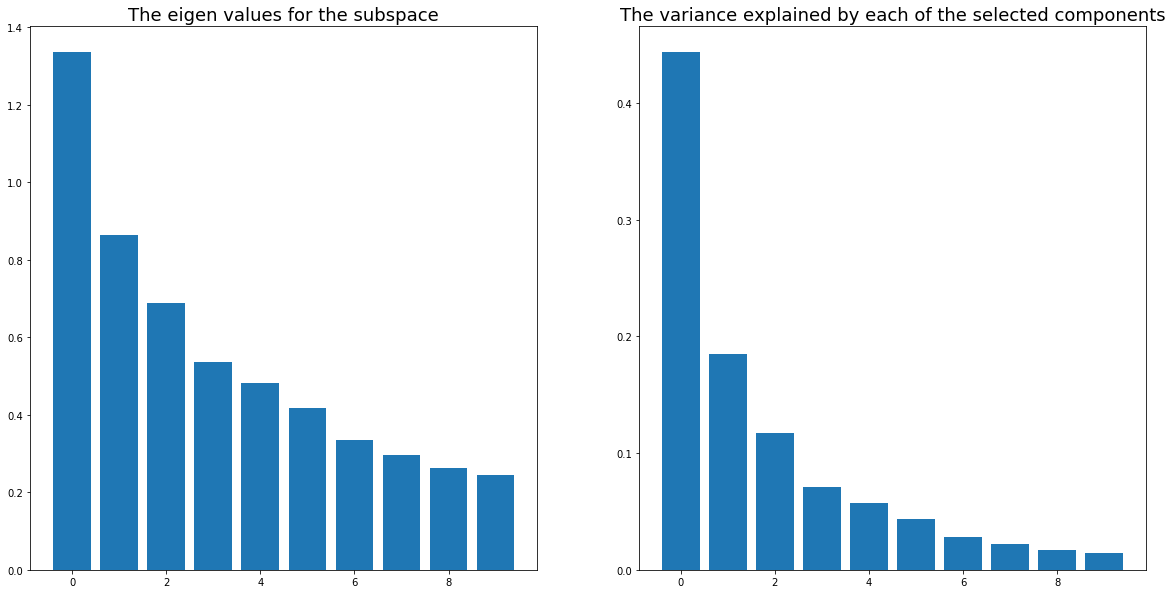

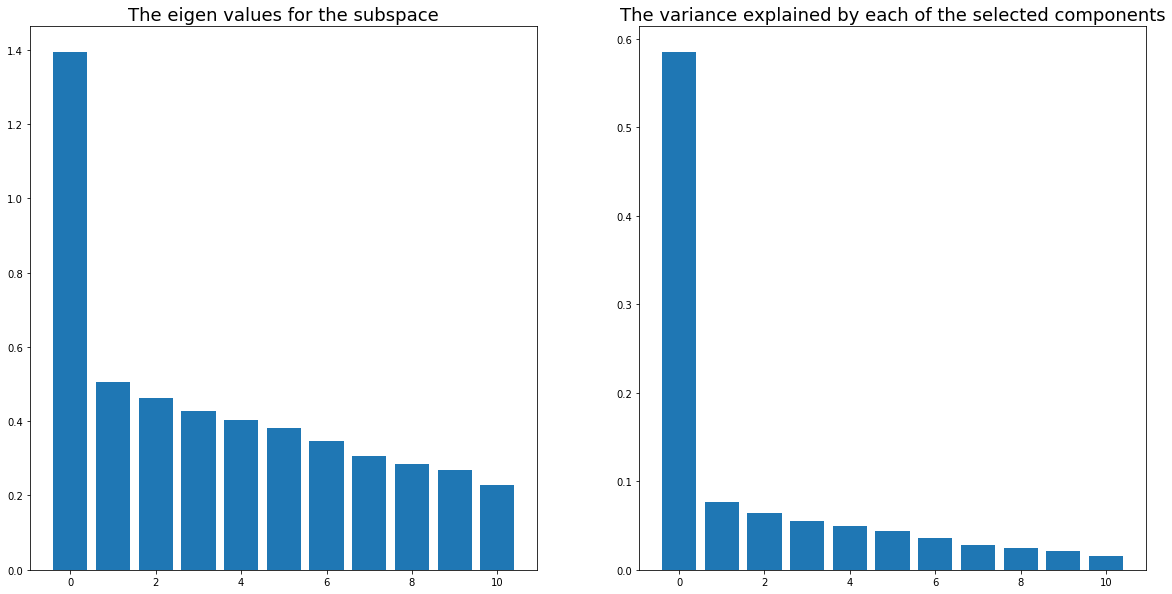

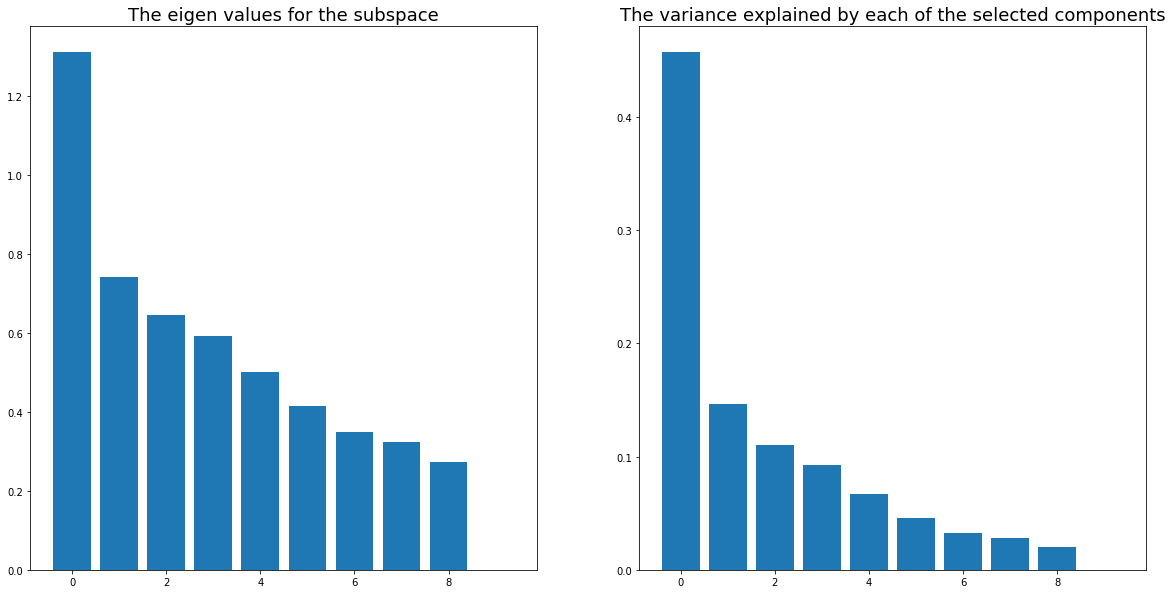

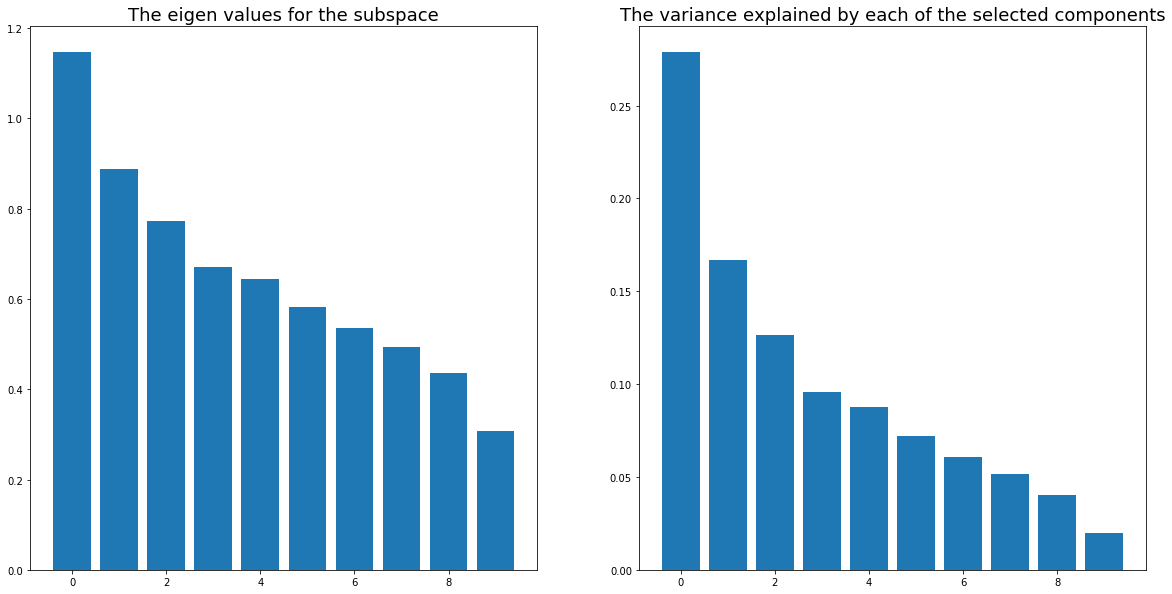

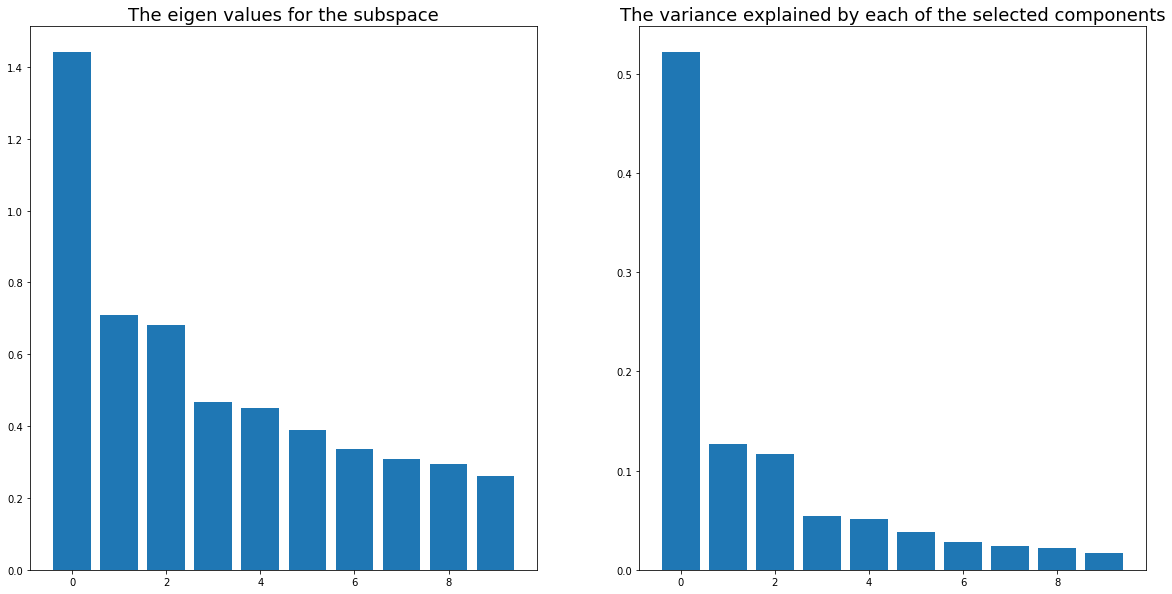

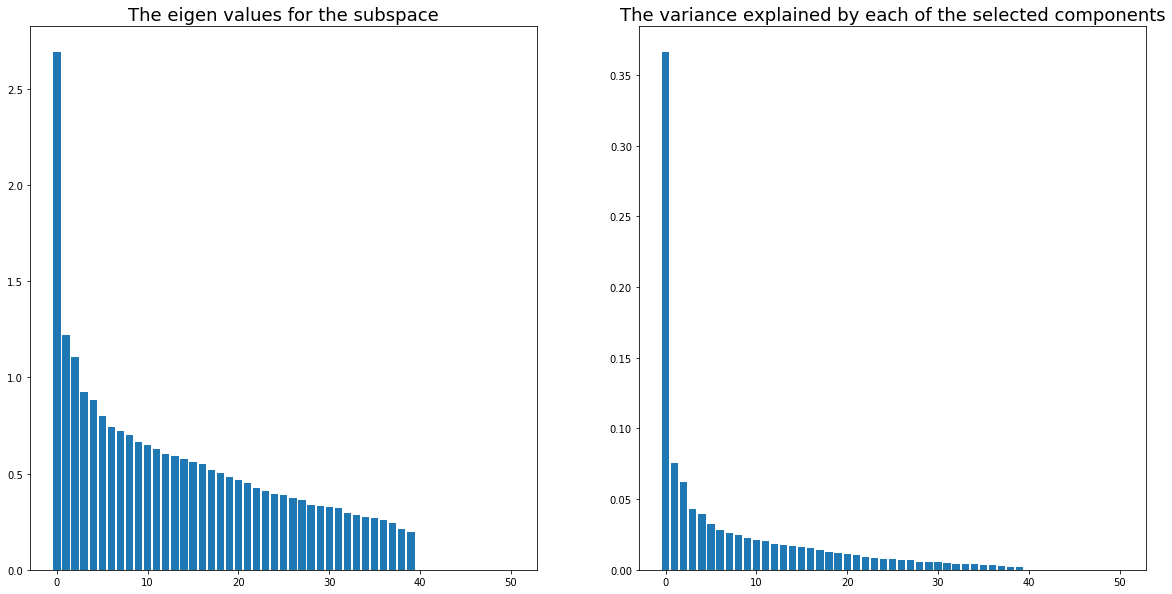

In [79]:
ax1 = lib.plot_var_eig(eig_values_g0,expl_var_g0)
ax1 = lib.plot_var_eig(eig_values_g1,expl_var_g1)
ax2 = lib.plot_var_eig(eig_values_g2,expl_var_g2)
axM = lib.plot_var_eig(eig_values_gM,expl_var_gM)
axh = lib.plot_var_eig(eig_values_gh,expl_var_gh)
axALL = lib.plot_var_eig(eig_values_gall,expl_var_gall)

## Exemple of  direct biais

#####################
#    biaised Words   #
#####################


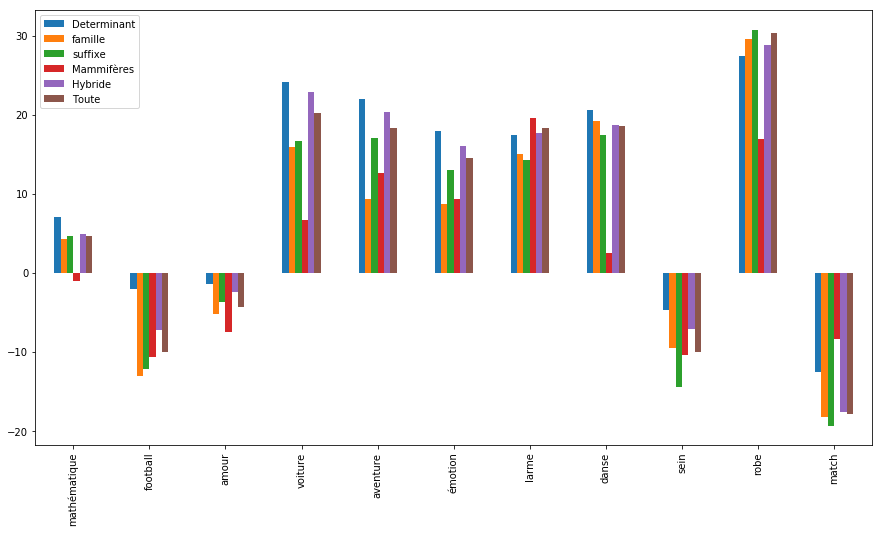

In [130]:
word = ['mathématique','football','amour','voiture','aventure','émotion','larme','danse','sein','robe','match']
print('#####################')
print('#    biaised Words   #')
print('#####################')
G,G1,G2,GM,GH,ALL = [],[],[],[],[],[]
for w in word :
    G.append( lib.cosine_similarity(model[w],direction_g0)*100)
    G1.append( lib.cosine_similarity(model[w],direction_g1)*100)
    G2.append( lib.cosine_similarity(model[w],direction_g2)*100)
    GM.append( lib.cosine_similarity(model[w],direction_gM)*100)
    GH.append( lib.cosine_similarity(model[w],direction_gh)*100)
    ALL.append( lib.cosine_similarity(model[w],direction_gall)*100)
res = pd.DataFrame(data={'Determinant':G,'famille':G1,'suffixe':G2,'Mammifères':GM,'Hybride':GH,'Toute':ALL},index=word)
res.plot.bar(figsize=(15,8))
plt.show()

########################
#    feminin Words      #
########################


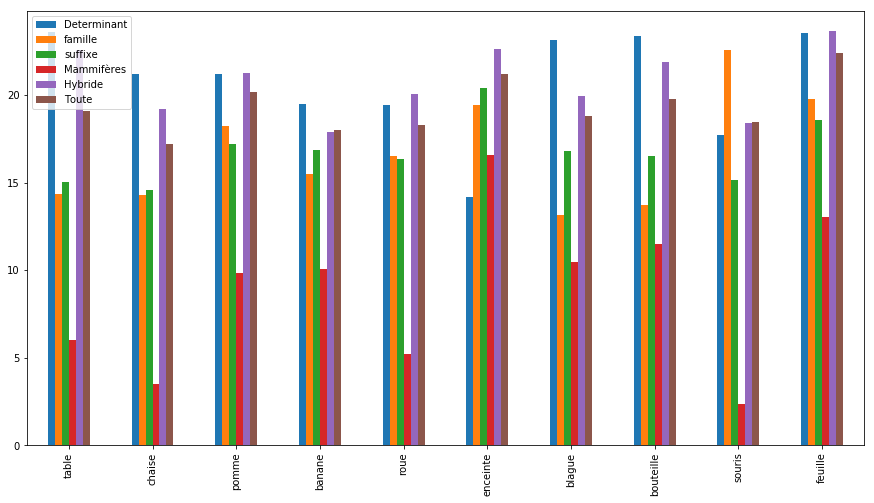

In [127]:
neutral_fem =['table','chaise','pomme','banane','roue','enceinte','blague','bouteille','souris','feuille']
print('########################')
print('#    feminin Words      #')
print('########################')
G,G1,G2,GM,GH,ALL = [],[],[],[],[],[]
for w in neutral_fem :
    G.append( lib.cosine_similarity(model[w],direction_g0)*100)
    G1.append( lib.cosine_similarity(model[w],direction_g1)*100)
    G2.append( lib.cosine_similarity(model[w],direction_g2)*100)
    GM.append( lib.cosine_similarity(model[w],direction_gM)*100)
    GH.append( lib.cosine_similarity(model[w],direction_gh)*100)
    ALL.append( lib.cosine_similarity(model[w],direction_gall)*100)
res = pd.DataFrame(data={'Determinant':G,'famille':G1,'suffixe':G2,'Mammifères':GM,'Hybride':GH,'Toute':ALL},index=neutral_fem)
res.plot.bar(figsize=(15,8))
plt.show()

########################
#    masculin Words     #
########################


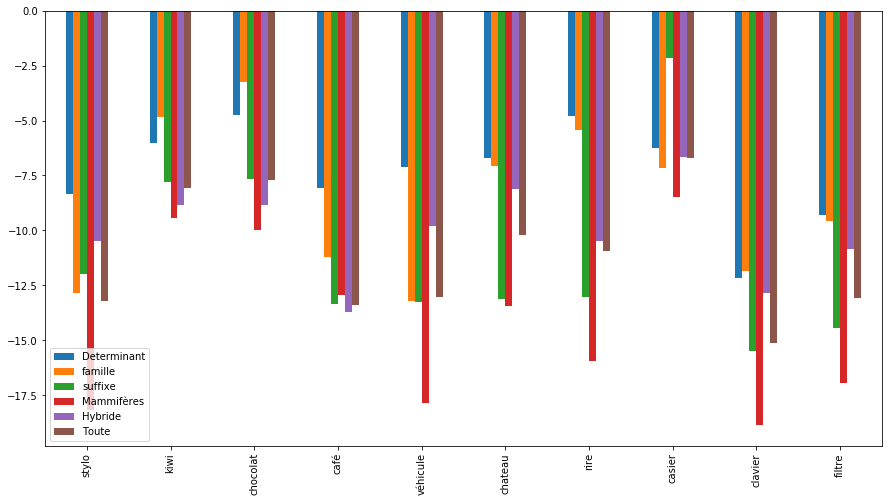

In [128]:
neutral_man =['stylo','kiwi','chocolat','café','véhicule','chateau','rire','casier','clavier','filtre']
print('########################')
print('#    masculin Words     #')
print('########################')
G,G1,G2,GM,GH,ALL = [],[],[],[],[],[]
for w in neutral_man :
    G.append( lib.cosine_similarity(model[w],direction_g0)*100)
    G1.append( lib.cosine_similarity(model[w],direction_g1)*100)
    G2.append( lib.cosine_similarity(model[w],direction_g2)*100)
    GM.append( lib.cosine_similarity(model[w],direction_gM)*100)
    GH.append( lib.cosine_similarity(model[w],direction_gh)*100)
    ALL.append( lib.cosine_similarity(model[w],direction_gall)*100)
res = pd.DataFrame(data={'Determinant':G,'famille':G1,'suffixe':G2,'Mammifères':GM,'Hybride':GH,'Toute':ALL},index=neutral_man)
res.plot.bar(figsize=(15,8))
plt.show()

## First conclusion :
We observe that the sign of the direct biais correspond to gramatical gender! Let's verify this hypothesis by implemented a classifier to infer the gramatical Gender.

In [89]:
#Load lexique in a Dataframe
df = pd.read_excel(r'DATA\FR\Lexique382.xlsx',encoding='latin1')

In [140]:
def Gender_Classifier_predict(X,Pair,model):
    """
    predict the gender of a noum based on the 
    """
    direction_g, expl_var_g,eig_values_g = lib.from_pair_to_direction2(Pair,model)
    Y_pred = []
    for i in range(len(X)):
        if lib.cosine_similarity(X[i],direction_g)*100>0:
            Y_pred.append(0)
        else :
            Y_pred.append(1)
    return(Y_pred)

def store_score(pair,model,lexique):
    X,y = lib.built_X_y(lib.merge_model_lexique(df,model),model)
    Y_pred = Gender_Classifier_predict(X,pair,model)
    Y_pred_rand = np.random.randint(2, size=len(X))
    roc = roc_auc_score(y, Y_pred)
    acc = accuracy_score(y, Y_pred)
    roc_rand = roc_auc_score(y, Y_pred_rand)
    acc_rand = accuracy_score(y, Y_pred_rand)
    return(roc,acc,roc_rand,acc_rand)

def store_result(MODEL,MODEL_NAME,pair,lexique):
    ROC,ROC_R = [],[]
    ACC ,ACC_R = [],[]
    for model in MODEL:
        try :
            roc,acc,roc_rand,acc_rand = store_score(pair,model,lexique)
        except :
            #roc,acc,roc_rand,acc_rand = store_score(pair,model,lexique)
            roc,acc,roc_rand,acc_rand = 0,0,0,0
        ROC.append(roc)
        ACC.append(acc)
        ROC_R.append(roc_rand)
        ACC_R.append(acc_rand)
    df = pd.DataFrame(data = {'ROC':ROC,'ACC':ACC,'ROC_random':ROC_R,'ACC_Random':ACC_R},index=MODEL_NAME)
    return(df)
        
    
 
    

## We modify some of the pair to have some result with the lemmatized corpus

In [154]:

# we remind the pair here
pair_g = [['la','le'],['elle','il'], ['cette', 'cet'],
          ['une','un'],['laquelle', 'lequel'],['celle','celui'],['ma','mon'],
          ['mienne','mien'],['certaine', 'certain'],['aucune', 'aucun']
         ]

pair_g1 = [['femme','homme'],['maman','papa'],['mère','père'],['femelle','mâle'],
           ['reine','roi'],['tante','oncle'],
           ['fille','garçon'],['marraine','parrain']
          ]


pair_g2 = [['belle','beau'],['actrice','acteur'],['serveuse','serveur'],['contente' ,'content'],
           ['petite','petit'],['heureuse','heureux'],['gentille','gentils'],['seule', 'seul'],
           ['créatrice','créateur'],['chanteuse','chanteuse']]

pair_am = [['brebis', 'bélier'], ['chèvre', 'bouc'],['biche', 'cerf'],
            ['jument', 'cheval'], ['poule', 'coq'],
           ['louve', 'loup'],['rate', 'rat'],['vache', 'taureau']]

pair_h =[['femme','homme'],['fille','garçon'],['femelle','mâle'],
         ['la','le'],['elle','il'],
         ['jument', 'cheval'],['louve', 'loup']
        ]
pair_all= pair_g+pair_g1+pair_g2+pair_am+pair_h

In [92]:
print('##########################')
print('#    paires déterminant   #')
print('##########################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_0 = store_result(MODEL,MODEL_NAME,pair_g,df)
df_0

##########################
#    pair_ déterminant   #
##########################


,ROC,ACC,ROC_random,ACC_Random
model,0.877169,0.862642,0.498708,0.499108
model_lem,0.000000,0.000000,0.000000,0.000000
model_wiki,0.799666,0.786190,0.508629,0.508385
model_wiki_lem,0.000000,0.000000,0.000000,0.000000


In [156]:
print('######################')
print('#    paires famille   #')
print('######################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_1 = store_result(MODEL,MODEL_NAME,pair_g1,df)
df_1

######################
#    paires famille   #
######################


,ROC,ACC,ROC_random,ACC_Random
model,0.880025,0.880583,0.500166,0.500446
model_lem,0.541448,0.554889,0.495954,0.497019
model_wiki,0.667448,0.657292,0.501969,0.502331
model_wiki_lem,0.511175,0.654203,0.500556,0.500603


In [132]:
print('####################')
print('#    paires suffixe  #')
print('####################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_2 = store_result(MODEL,MODEL_NAME,pair_g2,df)
df_2

####################
#    paires suffixe  #
####################


,ROC,ACC,ROC_random,ACC_Random
model,0.880506,0.890360,0.499605,0.499383
model_lem,0.539770,0.645681,0.498911,0.499260
model_wiki,0.226986,0.230369,0.498312,0.497881
model_wiki_lem,0.000000,0.000000,0.000000,0.000000


In [157]:
print('##########################')
print('#    paires mamifères   #')
print('##########################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_0 = store_result(MODEL,MODEL_NAME,pair_am,df)
df_0

##########################
#    paires mamifères   #
##########################


,ROC,ACC,ROC_random,ACC_Random
model,0.812799,0.811630,0.496618,0.497015
model_lem,0.502468,0.521853,0.499006,0.499829
model_wiki,0.392225,0.407822,0.502038,0.501695
model_wiki_lem,0.478475,0.613399,0.501547,0.501499


In [158]:
print('##########################')
print('#    paires hybride      #')
print('##########################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_0 = store_result(MODEL,MODEL_NAME,pair_h,df)
df_0

##########################
#    paires hybride      #
##########################


,ROC,ACC,ROC_random,ACC_Random
model,0.861285,0.857770,0.497640,0.498113
model_lem,0.469582,0.374445,0.501895,0.501804
model_wiki,0.283884,0.278168,0.501155,0.501150
model_wiki_lem,0.498924,0.638005,0.501153,0.501844


In [99]:
print('##########################')
print('#    paires all      #')
print('##########################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_0 = store_result(MODEL,MODEL_NAME,pair_all,df)
df_0

##########################
#    paires all      #
##########################


,ROC,ACC,ROC_random,ACC_Random
model,0.898733,0.896295,0.503282,0.503808
model_lem,0.000000,0.000000,0.000000,0.000000
model_wiki,0.000000,0.000000,0.000000,0.000000
model_wiki_lem,0.000000,0.000000,0.000000,0.000000


In [105]:
print('############################')
print('#    Déterminants, familles #')
print('############################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_01 = store_result(MODEL,MODEL_NAME,pair_g+pair_g1,df)
df_01

############################
#    Déterminants, familles #
############################


,ROC,ACC,ROC_random,ACC_Random
model,0.914133,0.909262,0.498415,0.498182
model_lem,0.000000,0.000000,0.000000,0.000000
model_wiki,0.000000,0.000000,0.000000,0.000000
model_wiki_lem,0.000000,0.000000,0.000000,0.000000


In [104]:
print('#############################')
print('#    détermiannt +suffixe  #')
print('#############################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_02 = store_result(MODEL,MODEL_NAME,pair_g+pair_g2,df)
df_02

#############################
#    détermiannt +suffixe  #
#############################


,ROC,ACC,ROC_random,ACC_Random
model,0.909931,0.908268,0.505378,0.505729
model_lem,0.000000,0.000000,0.000000,0.000000
model_wiki,0.817931,0.809227,0.499132,0.499455
model_wiki_lem,0.000000,0.000000,0.000000,0.000000


In [106]:
print('##############################')
print('#    Suffixe, famille, det #')
print('##############################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_012 = store_result(MODEL,MODEL_NAME,pair_g+pair_g1+pair_g2,df)
df_012

##############################
#    Suffixe, famille, det #
##############################


,ROC,ACC,ROC_random,ACC_Random
model,0.915273,0.915506,0.498236,0.498079
model_lem,0.000000,0.000000,0.000000,0.000000
model_wiki,0.000000,0.000000,0.000000,0.000000
model_wiki_lem,0.000000,0.000000,0.000000,0.000000


In [107]:
 print('##############################')
print('#     famille, animaux  #')
print('##############################')
MODEL = [model,model_lem,model_wiki,model_wiki_lem]
MODEL_NAME = ['model','model_lem','model_wiki','model_wiki_lem']
df_012 = store_result(MODEL,MODEL_NAME,pair_g1+pair_am,df)
df_012

##############################
#     famille, animaux  #
##############################


,ROC,ACC,ROC_random,ACC_Random
model,0.876911,0.880515,0.497305,0.496638
model_lem,0.473568,0.471692,0.506520,0.505943
model_wiki,0.000000,0.000000,0.000000,0.000000
model_wiki_lem,0.000000,0.000000,0.000000,0.000000
